In [1]:
import torch
import torchvision
import os
import urllib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Load the pre-trained weights of a DeepLabV3 CNN with a MobileNetV3 backbone
weights = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
deeplabv3 = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=weights,
                                                                             progress=False)
deeplabv3.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [3]:
# Extract the transformation pipeline and the list of categories from the weights object
transform = weights.transforms()
categories = weights.meta["categories"]
# Print the list of catgegories
print(f"categories = {categories}")
# Define a dictionary mapping the category index to an arbitrary color
index_to_color = {0: (0, 0, 0),
                      1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255),
                      4: (255, 255, 0), 5: (255, 0, 255), 6: (255, 255, 0),
                      7: (64, 128, 255), 8: (64, 255, 128), 9: (128, 64, 255),
                      10: (128, 255, 64), 11: (255, 64, 128), 12: (255, 128, 64),
                      13: (32, 110, 170), 14: (32, 170, 110), 15: (110, 32, 170),
                      16: (110, 170, 32), 17: (170, 32, 110), 18: (170, 110, 32),
                      19: (100, 140, 200), 20: (100, 200, 140)}

categories = ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [4]:
# Define a list of image URLs
image_url_list = ["https://live.staticflickr.com/6137/6004108221_baed02a7d7_z.jpg",
                 "https://live.staticflickr.com/5745/21046188832_2c9e0be64c_z.jpg",
                 "https://live.staticflickr.com/1/1212678_5559f93c91_z.jpg"]

In [6]:
# Loop through the images and pass them through the semantic segmentation CNN
original_imgs = []
semantic_segmentation_imgs = []
with torch.no_grad():
    for img_ndx in range(len(image_url_list)):
        with urllib.request.urlopen(image_url_list[img_ndx]) as url:
            image_pil = Image.open(url)
            original_imgs.append(image_pil)
            # Create a batch tensor by adding a dummy dimension 0 the image tensor
            batch_tsr = transform(image_pil).unsqueeze(0)  
            output = deeplabv3(batch_tsr)
            semantic_segmentation_shapeNCHW = output['out'].shape
            # Create a semantic segmentation color image
            semantic_segmentation_img = np.zeros((semantic_segmentation_shapeNCHW[2], semantic_segmentation_shapeNCHW[3], 3), dtype=np.uint8)
            # Create a tensor holding the index of the highest logit
            semantic_segmentation_index_tsr = torch.argmax(output['out'][0, :, :, :], dim=0)  # (H, W)
            # For each pixel, convert the index to a color
            for y in range(semantic_segmentation_img.shape[0]):
                for x in range(semantic_segmentation_img.shape[1]):
                    index = semantic_segmentation_index_tsr[y, x].item()
                    color = index_to_color[index]
                    semantic_segmentation_img[y, x, [0, 1, 2]] = color
            # Resize to the original size, without interpolation, i.e. using the nearest neighbor color
            width, height = image_pil.size
            semantic_segmentation_img = cv2.resize(semantic_segmentation_img, (width, height),
                                                       interpolation=cv2.INTER_NEAREST)
            semantic_segmentation_imgs.append(semantic_segmentation_img)

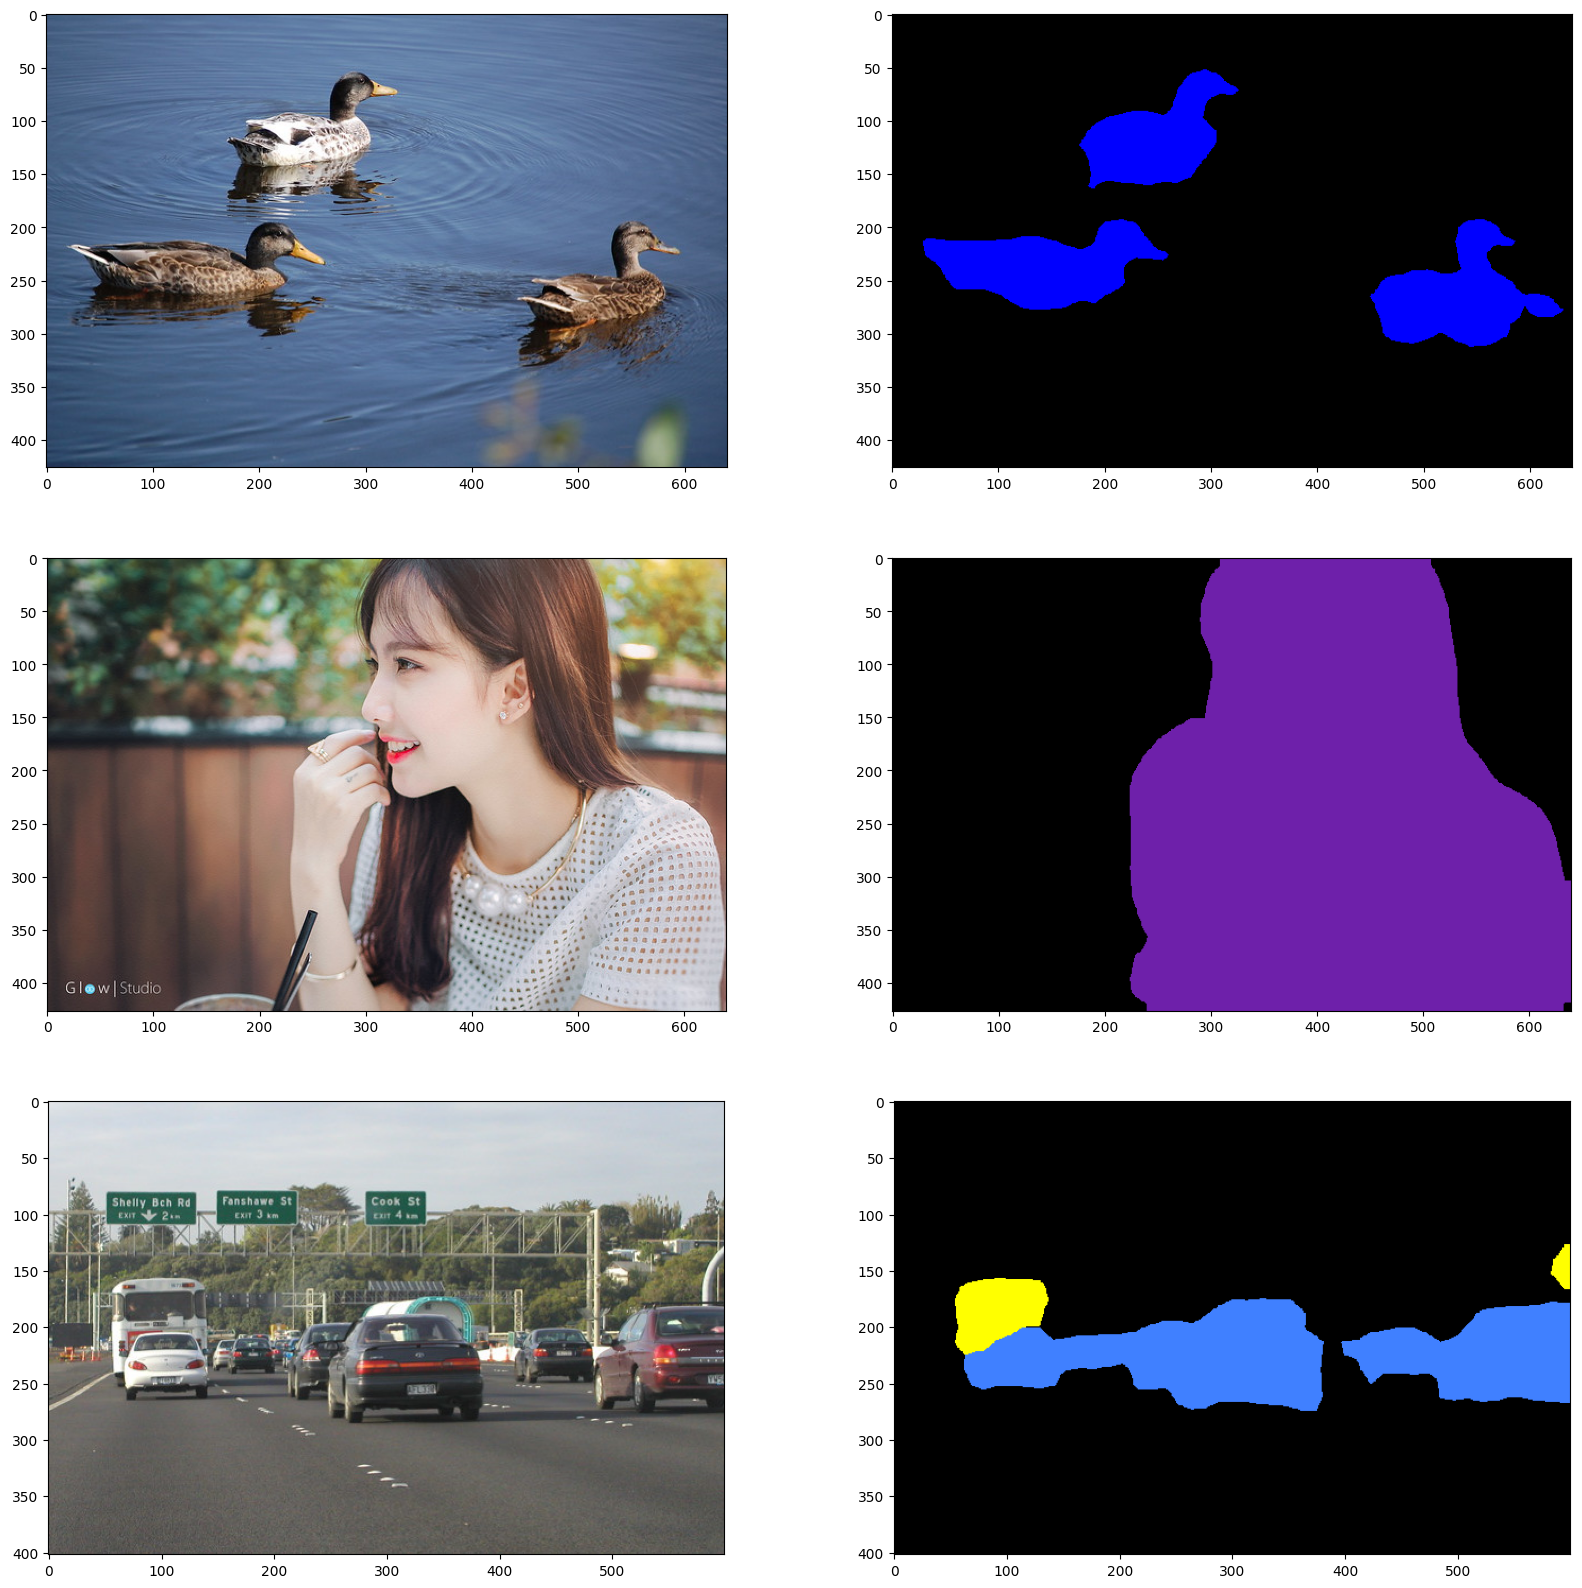

In [7]:
# Display the images
fig, axs = plt.subplots(nrows=len(original_imgs), ncols=2, figsize=(20, 20))
for img_ndx in range(len(original_imgs)):
    axs[img_ndx, 0].imshow(original_imgs[img_ndx])
    axs[img_ndx, 1].imshow(semantic_segmentation_imgs[img_ndx])